In [125]:
import os
import glob

example_aug_tensor_name = "187524_1_5dff_9088_6592_touchcount_0_brightened_1.0844444036483765.pt"

path = "/home/FungAI/notebooks/paint_annos/anno_crops_encodings_stacked_iciarstyle"  
pt_files = os.listdir(path)  
pt_files = [f"{path}/{pt_file}" for pt_file in pt_files]
print(len(pt_files))

20400


In [167]:
# CLEAN pt files, because they all have touchcount_0_ because some mistake... So I need to match all of them up with the 
# files in /home/FungAI/notebooks/paint_annos/anno_crops_encodings_stacked_iciarstyle that have a A_ and give the correct touchcount
from pathlib import Path
import re 

def get_sagsinfo_and_crop_coords(string):
    if string[:2] == "A_": string = string[2:]
    sagsinfo_crop = string.split("_")[:5] # e.g. '186962_1_1dff_18176_16480'
    idx = "_".join(sagsinfo_crop)
    return idx

def get_dict_of_touchcounts(masks):
    touchcount_dict = {}
    for mask in masks: 
        maskname = Path(mask).name
        if "A_" not in maskname: continue
        idx = get_sagsinfo_and_crop_coords(maskname)
        touchcount = maskname[2:].split("_")[6]
        touchcount_dict[idx] = maskname[2:].split("_")[6].split(".")[0]
    return touchcount_dict 

def get_touchcount_from_encodingspath(string):
    match = re.search(r"touchcount_(\d+)_", string)
    if match: return (match.group(1))
    else: return False
    


path = "/home/FungAI/notebooks/paint_annos/anno_crops" 
masks = os.listdir(path)  
masks = [f"{path}/{mask}" for mask in masks]

touchcount_dict = get_dict_of_touchcounts(masks)

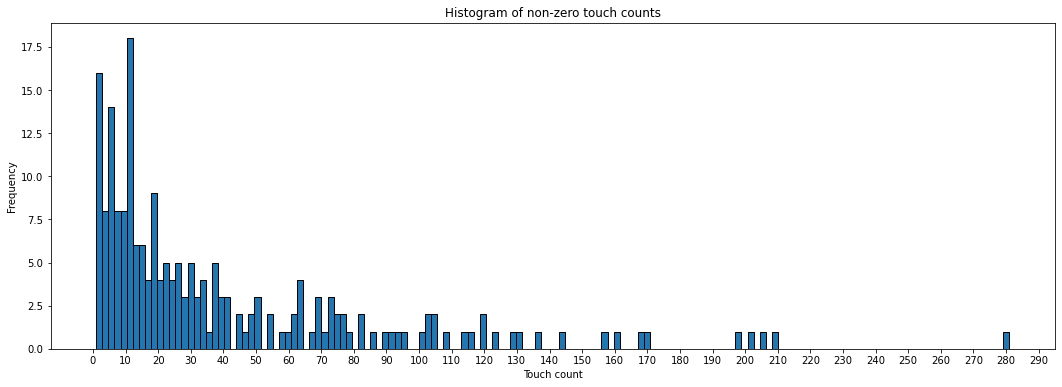

In [170]:
import matplotlib.pyplot as plt

# create a dictionary with some values
my_dict = touchcount_dict

# extract the values from the dictionary
values = list(my_dict.values())
values = [int(v) for v in values]
values = sorted(values, key=int)

values = [v for v in values if v > 0]

plt.figure(figsize=(18, 6))
# plot the histogram of the values
plt.hist(values, bins=150, edgecolor='black')

plt.xticks(range(0, max(values)+10, 10))

# add labels and title
plt.xlabel('Touch count')
plt.ylabel('Frequency')
plt.title('Histogram of non-zero touch counts')

# show the plot
plt.show()

In [159]:
# there are 10 brightness augmentations per crop. The test set should only include the brightness closest to 1, and not
# the other augmentations. So sort the crops

def get_sublists_of_10(lst):
    n = len(lst)
    slices = []
    for i in range(0, n, 10):
        slices.append(lst[i:i+10])
    return slices

pt_files.sort()
crops = get_sublists_of_10(pt_files)

# shuffle 
import random
random.seed(666)
random.shuffle(crops)

In [160]:
a = int(len(crops) * 0.25)

test_crops = crops[:a]
train_crops = crops[a:]

print(len(test_crops))
print(len(train_crops))

510
1530


In [161]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import torch
from pathlib import Path

def getTrainTestTensorsAndLabels(positive_threshold, train_crops, test_crops):
    #Capture training data and labels into respective lists
    train_images = []
    train_labels = [] 
    test_images = []
    test_labels = []

    for crop_augs in train_crops: 
        for crop in crop_augs:
            cropname = Path(crop).name
            descriptor_tensor = torch.load(crop).flatten()
            train_images.append(descriptor_tensor)
            touchcount = int(touchcount_dict[get_sagsinfo_and_crop_coords(cropname)])
            if touchcount >= positive_threshold: train_labels.append(1)
            else: train_labels.append(0)

    for crop_augs in test_crops: 
        for crop in crop_augs:
            cropname = Path(crop).name
            if "10844444036483765" not in cropname: continue # this is the brightness value closest to 1... Not perfect, but I'm an idiot
            descriptor_tensor = torch.load(crop).flatten()
            test_images.append(descriptor_tensor)
            touchcount = int(touchcount_dict[get_sagsinfo_and_crop_coords(cropname)])
            if touchcount >= positive_threshold: test_labels.append(1)
            else: test_labels.append(0)

    #Convert lists to arrays        
    train_images = torch.stack(train_images, dim=0)
    train_labels = torch.tensor(train_labels)
    
    assert train_labels.sum() > 0

    test_images = torch.stack(test_images, dim=0)
    test_labels = torch.tensor(test_labels)
    
    assert test_labels.sum() > 0
    
    return train_images, train_labels, test_images, test_labels

In [162]:
#XGBOOST
import xgboost as xgb
import time 

def train_and_get_test_metrics(train_images, train_labels, test_images, test_labels):
    model = xgb.XGBClassifier()

    start_time = time.perf_counter()

    model.fit(train_images, train_labels) #For sklearn no one hot encoding

    end_time = time.perf_counter()

    elapsed_time = end_time - start_time
    print(f"Training time: {elapsed_time:.6f} seconds")
    
    #Now predict using the trained RF model. 
    prediction = model.predict(test_images)
    #Print overall accuracy
    #Print overall accuracy
    from sklearn import metrics
    from sklearn.metrics import confusion_matrix
    print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction))
    print ("F1 = ", metrics.f1_score(test_labels, prediction))
    print ("CM: ")
    print(confusion_matrix(test_labels, prediction))
    return model
    
def train_and_get_test_metrics_of_threshold(positive_threshold, train_crops, test_crops):
    train_images, train_labels, test_images, test_labels = getTrainTestTensorsAndLabels(positive_threshold, train_crops, test_crops)
    model = train_and_get_test_metrics(train_images, train_labels, test_images, test_labels)
    return model



In [164]:
for i in range(1,10):
    print("------ training and testing with touch_count threshold ", i)
    train_and_get_test_metrics_of_threshold(i, train_crops, test_crops)
    print("******")

------ training and testing with touch_count threshold  1
Training time: 242.914921 seconds
Accuracy =  0.9117647058823529
F1 =  0.41558441558441556
CM: 
[[449  12]
 [ 33  16]]
******
------ training and testing with touch_count threshold  2
Training time: 240.280061 seconds
Accuracy =  0.9254901960784314
F1 =  0.4571428571428571
CM: 
[[456   7]
 [ 31  16]]
******
------ training and testing with touch_count threshold  3
Training time: 240.624733 seconds
Accuracy =  0.9176470588235294
F1 =  0.4166666666666667
CM: 
[[453  12]
 [ 30  15]]
******
------ training and testing with touch_count threshold  4
Training time: 232.041518 seconds
Accuracy =  0.9294117647058824
F1 =  0.4705882352941177
CM: 
[[458   9]
 [ 27  16]]
******
------ training and testing with touch_count threshold  5
Training time: 237.405055 seconds
Accuracy =  0.9274509803921569
F1 =  0.4307692307692308
CM: 
[[459   9]
 [ 28  14]]
******
------ training and testing with touch_count threshold  6
Training time: 227.602737 

## TRY BALANCING THE CLASSES! 

## ALL INCORRECT GUESSES WERE POS... MAYBE SHOW THE ORIGINALS TO SEE IF THEY HAVE SMTH IN COMMON

In [115]:
indices_incorrectly_classified = (test_labels != torch.from_numpy(prediction)).nonzero().flatten()
print(indices_incorrectly_classified)

tensor([ 27,  31,  62,  92, 102, 103, 109, 117, 120, 122, 125, 129, 134, 147,
        148, 163, 168, 175, 185, 210, 226, 240, 248, 272, 275, 277, 286, 288,
        291, 294, 320, 326, 338, 355, 358, 377, 401, 414, 418, 426, 439, 441,
        447, 459, 474])


In [116]:
a = test_labels
b = torch.from_numpy(prediction)

indices = torch.nonzero((a == 1) & (b == 0))

# Get the elements where a has 1 and b has 0
elements = a[indices]

In [118]:
elements.sum()

tensor(33)

In [123]:
len(prediction)
sum(prediction)

28